In [1]:
import copy
import torch
import argparse
import numpy as np
import umap
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, f1_score, roc_auc_score, roc_curve, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import numbers
import torch.nn as nn
# from cac import batch_cac
# from kmeans import batch_KMeans
from meanshift import batch_MeanShift
from autoencoder import AutoEncoder
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

In [2]:
## k-Means
def _parallel_compute_distance(X, cluster):
    n_samples = X.shape[0]
    dis_mat = np.zeros((n_samples, 1))
    for i in range(n_samples):
        dis_mat[i] += np.sqrt(np.sum((X[i] - cluster) ** 2, axis=0))
    return dis_mat


class batch_KMeans(object):
    def __init__(self, args):
        self.args = args
        self.latent_dim = args.latent_dim
        self.n_clusters = args.n_clusters
        self.clusters = np.zeros((self.n_clusters, self.latent_dim))
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs
        self.positive_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.negative_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.cluster_stats = np.zeros((self.n_clusters,2))

    
    def _compute_dist(self, X):
        dis_mat = Parallel(n_jobs=self.n_jobs)(
            delayed(_parallel_compute_distance)(X, self.clusters[i])
            for i in range(self.n_clusters))
        dis_mat = np.hstack(dis_mat)
        
        return dis_mat


    def init_cluster(self, X, y=None, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
        labels = model.labels_

        for j in range(self.n_clusters):
            pts_index = np.where(labels == j)[0]
            cluster_pts = X[pts_index]        
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            self.negative_centers[j,:] = n_class.mean(axis=0)
            self.positive_centers[j,:] = p_class.mean(axis=0)


    def update_cluster(self, X, cluster_idx):
        """ Update clusters in Kmeans on a batch of data """
        n_samples = X.shape[0]
        for i in range(n_samples):
            self.count[cluster_idx] += 1
            eta = 1.0 / self.count[cluster_idx]
            updated_cluster = ((1 - eta) * self.clusters[cluster_idx] + 
                               eta * X[i])
            self.clusters[cluster_idx] = updated_cluster
    

    def update_assign(self, X, y=None):
        """ Assign samples in `X` to clusters """
        dis_mat = self._compute_dist(X)
        new_labels = np.argmin(dis_mat, axis=1)

        if y is not None:
            for j in range(self.n_clusters):
                pts_index = np.where(new_labels == j)[0]
                cluster_pts = X[pts_index]        
                n_class_index = np.where(y[pts_index] == 0)[0]
                p_class_index = np.where(y[pts_index] == 1)[0]

                self.cluster_stats[j][0] = len(p_class_index)
                self.cluster_stats[j][1] = len(n_class_index)

                n_class = cluster_pts[n_class_index]
                p_class = cluster_pts[p_class_index]

                self.negative_centers[j,:] = n_class.mean(axis=0)
                self.positive_centers[j,:] = p_class.mean(axis=0)

        return new_labels

In [36]:
import numpy as np
from sklearn.cluster import KMeans
from joblib import Parallel, delayed
from cac_main import specificity, sensitivity, best_threshold, cac,\
compute_euclidean_distance, calculate_gamma_old, calculate_gamma_new
import umap
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score as ari

class batch_cac(object):    
    def __init__(self, args):
        self.args = args
        self.latent_dim = args.latent_dim
        self.n_clusters = args.n_clusters
        self.cluster_stats = np.zeros((self.n_clusters,2))
        self.clusters = np.zeros((self.n_clusters, self.latent_dim))
        self.positive_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.negative_centers = np.zeros((self.n_clusters, self.latent_dim))
        self.positive_sse = np.zeros(self.n_clusters)
        self.negative_sse = np.zeros(self.n_clusters)
        self.count = 100 * np.ones((self.n_clusters))  # serve as learning rate
        self.n_jobs = args.n_jobs


    def calculate_gamma_old(self, pt, label, mu, mup, mun, p_sse, n_sse, cluster_stats, beta=1, alpha=2):
        p, n = cluster_stats[0], cluster_stats[1]
        if label == 0:
            mun_new = (n/(n-1))*mun - (1/(n-1))*pt
            mup_new = mup
            new_n_sse = (n/(n-1))*n_sse - (1/(n-1))*np.linalg.norm(pt-mun_new)*np.linalg.norm(pt-mun)
            new_p_sse = p_sse
            n_new = n-1
            p_new = p

        else:
            mup_new = (p/(p-1))*mup - (1/(p-1))*pt
            mun_new = mun
            new_p_sse = (p/(p-1))*p_sse - (1/(p-1))*np.linalg.norm(pt-mup_new)*np.linalg.norm(pt-mup)
            new_n_sse = n_sse
            p_new = p-1
            n_new = n

        mu_new = (p_new*mup_new + n_new*mun_new)/(p_new + n_new)
        new_lin_sep = np.sum(np.square(mun_new - mup_new))/(new_n_sse + new_p_sse)
        lin_sep = np.sum(np.square(mun - mup))/(n_sse + p_sse)
        mu_sep = np.sum(np.square(mu - mu_new))
        gamma_p = -beta*np.sum(np.square(mu-pt)) - (p+n-1) * mu_sep + (p+n) * alpha*lin_sep - (p+n-1)*alpha*new_lin_sep
        # gamma_p = -np.sum(np.square(mu-pt)) - (p+n-1) * mu_sep + alpha*lin_sep - alpha*new_lin_sep
        return gamma_p


    def calculate_gamma_new(self, pt, label, mu, mup, mun, p_sse, n_sse, cluster_stats, beta=1, alpha=2):
        p, n = cluster_stats[0], cluster_stats[1]
        if label == 0:
            mun_new = (n/(n+1))*mun + (1/(n+1))*pt
            mup_new = mup
            new_n_sse = (n/(n+1))*n_sse + (1/(n+1))*np.linalg.norm(pt-mun_new)*np.linalg.norm(pt-mun)
            new_p_sse = p_sse
            n_new = n+1
            p_new = p

        else:
            mup_new = (p/(p+1))*mup + (1/(p+1))*pt
            mun_new = mun
            new_p_sse = (p/(p+1))*p_sse + (1/(p+1))*np.linalg.norm(pt-mup_new)*np.linalg.norm(pt-mup)
            new_n_sse = n_sse
            p_new = p+1
            n_new = n

        mu_new = (p_new*mup_new + n_new*mun_new)/(p_new + n_new)
        new_lin_sep = np.sum(np.square(mun_new - mup_new))/(new_n_sse + new_p_sse)
        lin_sep = np.sum(np.square(mun - mup))/(n_sse + p_sse)
        mu_sep = np.sum(np.square(mu - mu_new))

        gamma_j = beta*np.sum(np.square(mu_new-pt)) + (p+n)*mu_sep + (p+n) * alpha*lin_sep - (p+n+1)*alpha*new_lin_sep
        # gamma_j = np.sum(np.square(mu_new-pt)) + (p+n)*mu_sep + alpha*lin_sep - alpha*new_lin_sep
        return gamma_j

    def predict_clusters(self, X_test, centers) -> np.array:
        K = centers.shape[0]
        dists = np.zeros(K)
        test_labels = np.zeros(X_test.shape[0])

        for pt in range(X_test.shape[0]):
            for k in range(K):
                min_dist = np.square(np.linalg.norm(centers[k] - X_test[pt]))
                dists[k] = min_dist
            test_labels[pt] = int(np.argmin(dists))
        return test_labels.astype(int)


    def update_cluster_centers(self, X, y, cluster_labels):
        for j in range(self.n_clusters):
            pts_index = np.where(cluster_labels == j)[0]
            cluster_pts = X[pts_index]        
            for pt in pts_index:
                self.count[j] += 1
                eta = 1/(self.count[j])
                self.clusters[j,:] = (1-eta)*self.clusters[j,:] + eta*X[pt]

                if y[pt] == 0:
                    self.negative_centers[j,:] = (1-eta)*self.negative_centers[j,:] +\
                                                    eta*X[pt]
                else:
                    self.positive_centers[j,:] = (1-eta)*self.positive_centers[j,:] +\
                                                    eta*X[pt]

            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]
            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)
            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]
            self.negative_sse[j] = np.square(np.linalg.norm(n_class - self.negative_centers[j]))
            self.positive_sse[j] = np.square(np.linalg.norm(p_class - self.positive_centers[j]))

        return None


    def update(self, X, y, labels, beta, alpha):
        total_iterations = 100
        k = self.n_clusters
        errors = np.zeros((total_iterations, k))
        lbls = []
        lbls.append(np.copy(labels))

        if len(np.unique(y)) == 1:
            return cluster_stats, labels, self.clusters, self.positive_centers, self.negative_centers

        old_p, old_n = np.copy(self.positive_centers), np.copy(self.negative_centers)

        for iteration in range(0, total_iterations):
            # print(cluster_stats)
            N = X.shape[0]
            cluster_label = []
            for index_point in range(N):
                distance = {}
                pt = X[index_point]
                pt_label = y[index_point]
                cluster_id = labels[index_point]
                p, n = self.cluster_stats[cluster_id][0], self.cluster_stats[cluster_id][1]
                new_cluster = old_cluster = labels[index_point]
                old_err = np.zeros(k)
                # Ensure that degeneracy is not happening
                if ((p > 2 and pt_label == 1) or (n > 2 and pt_label == 0)):
                    for cluster_id in range(0, k):
                        if cluster_id != old_cluster:
                            distance[cluster_id] = self.calculate_gamma_new(pt, pt_label, self.clusters[cluster_id], self.positive_centers[cluster_id],\
                                                    self.negative_centers[cluster_id], self.positive_sse[cluster_id], self.negative_sse[cluster_id], self.cluster_stats[cluster_id], beta, alpha)
                        else:
                            distance[cluster_id] = np.infty

                    old_gamma = self.calculate_gamma_old(pt, pt_label, self.clusters[old_cluster], self.positive_centers[old_cluster],\
                                                    self.negative_centers[old_cluster], self.positive_sse[old_cluster], self.negative_sse[old_cluster], self.cluster_stats[old_cluster], beta, alpha)
                    # new update condition
                    new_cluster = min(distance, key=distance.get)
                    new_gamma = distance[new_cluster]

                    if old_gamma + new_gamma < 0:
                        # Remove point from old cluster
                        p, n = self.cluster_stats[old_cluster] # Old cluster statistics
                        t = p + n

                        self.clusters[old_cluster] = (t/(t-1))*self.clusters[old_cluster] - (1/(t-1))*pt

                        if pt_label == 0:
                            new_mean = (n/(n-1))*self.negative_centers[old_cluster] - (1/(n-1)) * pt
                            old_mean = self.negative_centers[old_cluster]
                            self.negative_sse[old_cluster] = (n/(n-1))*self.negative_sse[old_cluster] - \
                                    (1/(n-1))*np.linalg.norm(pt-new_mean)*np.linalg.norm(pt-old_mean)
                            self.negative_centers[old_cluster] = new_mean
                            self.cluster_stats[old_cluster][1] -= 1

                        else:
                            new_mean = (p/(p-1))*self.positive_centers[old_cluster] - (1/(p-1)) * pt
                            old_mean = self.positive_centers[old_cluster]
                            self.positive_sse[old_cluster] = (p/(p-1))*self.positive_sse[old_cluster] - \
                                    (1/(p-1)) * np.linalg.norm(pt-new_mean)*np.linalg.norm(pt-old_mean)
                            self.positive_centers[old_cluster] = new_mean
                            self.cluster_stats[old_cluster][0] -= 1


                        # Add point to new cluster
                        p, n = self.cluster_stats[new_cluster] # New cluster statistics
                        t = p + n
                        self.clusters[new_cluster] = (t/(t+1))*self.clusters[new_cluster] + (1/(t+1))*pt

                        if pt_label == 0:
                            new_mean = (n/(n+1))*self.negative_centers[new_cluster] + (1/(n+1)) * pt
                            old_mean = self.negative_centers[new_cluster]
                            self.negative_sse[new_cluster] = (n/(n+1))*self.negative_sse[new_cluster] + \
                                    (1/(n+1)) * np.linalg.norm(pt-new_mean) * np.linalg.norm(pt-old_mean)
                            self.negative_centers[new_cluster] = new_mean
                            self.cluster_stats[new_cluster][1] += 1

                        else:
                            new_mean = (p/(p+1))*self.positive_centers[new_cluster] + (1/(p+1)) * pt
                            old_mean = self.positive_centers[new_cluster]
                            self.positive_sse[new_cluster] = (p/(p+1))*self.positive_sse[new_cluster] + \
                                    (1/(p+1)) * np.linalg.norm(pt-new_mean) * np.linalg.norm(pt-old_mean)
                            self.positive_centers[new_cluster] = new_mean
                            self.cluster_stats[new_cluster][0] += 1

                        labels[index_point] = new_cluster


            lbls.append(np.copy(labels))

            if ((lbls[iteration] == lbls[iteration-1]).all()) and iteration > 0:
                print("converged at itr: ", iteration)
                break

#         print("Mean of Delta Clusters")
#         print(np.mean(old_p-positive_centers), np.mean(old_n - negative_centers))

        return labels

    
    def cluster(self, X, y, beta, alpha):
        # Update assigned cluster labels to points
        cluster_labels = self.predict_clusters(X, self.clusters)

        # Do we need this really? ... yes
        self.update_cluster_centers(X, y, cluster_labels)

        # update cluster centers
        new_labels = self.update(X, y, cluster_labels, beta, alpha)

        return new_labels


    def init_cluster(self, X, y, indices=None):
        """ Generate initial clusters using sklearn.Kmeans """
        """ X will be AE embeddings """
        model = KMeans(n_clusters=self.n_clusters,
                       n_init=20)
        model.fit(X)
        self.clusters = model.cluster_centers_  # copy clusters
        labels = model.labels_

        for j in range(self.n_clusters):
            pts_index = np.where(labels == j)[0]
            cluster_pts = X[pts_index]
#             assert(np.allclose(self.clusters[j,:], cluster_pts.mean(axis=0)))
            n_class_index = np.where(y[pts_index] == 0)[0]
            p_class_index = np.where(y[pts_index] == 1)[0]

            self.cluster_stats[j][0] = len(p_class_index)
            self.cluster_stats[j][1] = len(n_class_index)

            n_class = cluster_pts[n_class_index]
            p_class = cluster_pts[p_class_index]

            self.negative_centers[j,:] = n_class.mean(axis=0)
            self.positive_centers[j,:] = p_class.mean(axis=0)

            self.negative_sse[j] = np.square(np.linalg.norm(n_class - self.negative_centers[j]))
            self.positive_sse[j] = np.square(np.linalg.norm(p_class - self.positive_centers[j]))

        # self.clusters = np.random.rand(self.n_clusters, self.latent_dim)  # copy clusters

    def update_assign(self, X, target=None):
        """ Assign samples in `X` to clusters """
        return self.predict_clusters(X, self.clusters)

In [29]:
def get_dataset(DATASET, base_dir):
    if DATASET == "cic":
        Xa = pd.read_csv(base_dir + "/CIC/cic_set_a.csv")
        Xb = pd.read_csv(base_dir + "/CIC/cic_set_b.csv")
        Xc = pd.read_csv(base_dir + "/CIC/cic_set_c.csv")

        ya = Xa['In-hospital_death']
        yb = Xb['In-hospital_death']
        yc = Xc['In-hospital_death']

        Xa = Xa.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xb = Xb.drop(columns=['recordid', 'Survival', 'In-hospital_death'])
        Xc = Xc.drop(columns=['recordid', 'Survival', 'In-hospital_death'])

        cols = Xa.columns

        scale = StandardScaler()
        Xa = scale.fit_transform(Xa)
        Xb = scale.fit_transform(Xb)
        Xc = scale.fit_transform(Xc)

        Xa = pd.DataFrame(Xa, columns=cols)
        Xb = pd.DataFrame(Xb, columns=cols)
        Xc = pd.DataFrame(Xc, columns=cols)

        Xa = Xa.fillna(0)
        Xb = Xb.fillna(0)
        Xc = Xc.fillna(0)

        X_train = pd.concat([Xa, Xb])
        y_train = pd.concat([ya, yb])

        X_test = Xc
        y_test = yc

        X = pd.concat([X_train, X_test]).to_numpy()
        y = pd.concat([y_train, y_test]).to_numpy()

    elif DATASET == "titanic":
        X_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_train.csv").to_numpy()
        X_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "X_test.csv").to_numpy()
        y_train = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_train.csv").to_numpy()
        y_test = pd.read_csv(base_dir + "/" + DATASET + "/" + "y_test.csv").to_numpy()

        X = np.vstack([X_train, X_test])
        y = np.vstack([y_train, y_test])
        # X = pd.concat([X_train, X_test]).to_numpy()
        # y = pd.concat([y_train, y_test]).to_numpy()

    else:
        X = pd.read_csv(base_dir + "/" + DATASET + "/" + "X.csv").to_numpy()
        y = pd.read_csv(base_dir + "/" + DATASET + "/" + "y.csv").to_numpy()

    y1 = []
    for i in range(len(y)):
        y1.append(y[i])
    y = np.array(y)
    return X, y

In [30]:
import torch
import numbers
import numpy as np
import torch.nn as nn
# from cac import batch_cac
# from kmeans import batch_KMeans
from meanshift import batch_MeanShift
from autoencoder import AutoEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, RidgeClassifier
from matplotlib import pyplot as plt

color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

class DCN(nn.Module):
    def __init__(self, args):
        super(DCN, self).__init__()
        self.args = args
        self.beta = args.beta  # coefficient of the clustering term
        #print("k-Means pretraining")
        self.lamda = args.lamda  # coefficient of the reconstruction term
        self.device = torch.device(args.device)
        
        # Validation check
        if not self.beta > 0:
            msg = 'beta should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.beta))
        
        if not self.lamda > 0:
            msg = 'lamda should be greater than 0 but got value = {}.'
            raise ValueError(msg.format(self.lamda))
        
        if len(self.args.hidden_dims) == 0:
            raise ValueError('No hidden layer specified.')
        print(args.clustering)
        if args.clustering == 'kmeans':
            self.clustering = batch_KMeans(args)
        elif args.clustering == 'meanshift':
            self.clustering = batch_MeanShift(args)
        elif args.clustering == "cac":
            self.clustering = batch_cac(args)
            self.classifier = args.classifier
            self.cluster_classifiers = []
            self.base_classifier = []
        else:
            raise RuntimeError('Error: no clustering chosen')
            
        self.autoencoder = AutoEncoder(args).to(self.device)
        self.criterion  = nn.MSELoss(reduction='sum')
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=args.lr,
                                          weight_decay=args.wd)
    
    def get_classifier(self, classifier):
        if classifier == "LR":
            model = LogisticRegression(random_state=0, max_iter=1000)
        elif classifier == "RF":
            model = RandomForestClassifier(n_estimators=10)
        elif classifier == "SVM":
            # model = SVC(kernel="linear", probability=True)
            model = LinearSVC(max_iter=5000)
            model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
        elif classifier == "Perceptron":
            model = Perceptron()
            model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
        elif classifier == "ADB":
            model = AdaBoostClassifier(n_estimators = 100)
        elif classifier == "DT":
            model = DecisionTreeClassifier()
        elif classifier == "LDA":
            model = LDA()
        elif classifier == "NB":
            model = MultinomialNB()
        elif classifier == "SGD":
            model = SGDClassifier(loss='log')
        elif classifier == "Ridge":
            model = RidgeClassifier()
            model.predict_proba = lambda X: np.array([model.decision_function(X), model.decision_function(X)]).transpose()
        elif classifier == "KNN":
            model = KNeighborsClassifier(n_neighbors=5)
        else:
            model = LogisticRegression(class_weight='balanced', max_iter=1000)
        return model

    """ Compute the Equation (5) in the original paper on a data batch """
    def _loss(self, X, cluster_id):
        batch_size = X.size()[0]
        rec_X = self.autoencoder(X)
        latent_X = self.autoencoder(X, latent=True)
        
        # Reconstruction error
        rec_loss = self.lamda * self.criterion(X, rec_X)
        
        # Regularization term on clustering
        km_loss = torch.tensor(0.).to(self.device)
        sep_loss = torch.tensor(0.).to(self.device)
        clusters = torch.FloatTensor(self.clustering.clusters).to(self.device)
        positive_clusters = torch.FloatTensor(self.clustering.positive_centers).to(self.device)
        negative_clusters = torch.FloatTensor(self.clustering.negative_centers).to(self.device)

        for i in range(batch_size):
            diff_vec = latent_X[i] - clusters[cluster_id[i]]
            sample_dist_loss = torch.matmul(diff_vec.view(1, -1),
                                            diff_vec.view(-1, 1))
            km_loss += 0.5 * self.beta * torch.squeeze(sample_dist_loss)
            
            if self.args.clustering == "cac":
                Sw = self.clustering.positive_sse[cluster_id[i]] + self.clustering.negative_sse[cluster_id[i]]
                diff_vec = (positive_clusters[cluster_id[i]] - negative_clusters[cluster_id[i]])
                sample_sep_loss = torch.matmul(diff_vec.view(1, -1),
                                                diff_vec.view(-1, 1))
                sep_loss -= self.args.alpha * torch.squeeze(sample_sep_loss) / Sw
        
        for j in range(self.args.n_clusters):
            Sw = self.clustering.positive_sse[cluster_id[i]] + self.clustering.negative_sse[cluster_id[i]]
            diff_vec = positive_clusters[j] - negative_clusters[j]
            sample_sep_loss = torch.matmul(diff_vec.view(1, -1),
                                            diff_vec.view(-1, 1))
            sample_sep_loss = torch.squeeze(sample_sep_loss) / Sw
            print("Class Dist: ", sample_sep_loss)

        print("KM Dist: ", km_loss)
        print("Sep Dist: ", sep_loss)

        return (rec_loss + km_loss + sep_loss,
                rec_loss.detach().cpu().numpy(),
                (km_loss + sep_loss).detach().cpu().numpy())
    
    def pretrain(self, train_loader, epoch=100, verbose=True):
        if not self.args.pretrain:
            return
        
        if not isinstance(epoch, numbers.Integral):
            msg = '`epoch` should be an integer but got value = {}'
            raise ValueError(msg.format(epoch))
        
        if verbose:
            print('========== Start pretraining ==========')
        
        rec_loss_list = []
        
        self.train()
        for e in range(epoch):
            for batch_idx, (data, _) in enumerate(train_loader):
                batch_size = data.size()[0]
                data = data.to(self.device).view(batch_size, -1)
                rec_X = self.autoencoder(data)
                loss = self.criterion(data, rec_X)
                if verbose and (batch_idx+1) % self.args.log_interval == 0:
                    msg = 'Epoch: {:02d} | Batch: {:03d} | Rec-Loss: {:.3f}'
                    print(msg.format(e, batch_idx+1, 
                                     loss.detach().cpu().numpy()))
                    rec_loss_list.append(loss.detach().cpu().numpy())
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
        self.eval()
        
        if verbose:
            print('========== End pretraining ==========\n')

        self.pre_cluster(train_loader)
                
        return rec_loss_list


    def pre_cluster(self, train_loader):
        # Initialize clusters in self.clustering after pre-training
        batch_X = []
        batch_y = []
        for batch_idx, (data, y) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.to(self.device).view(batch_size, -1)
            latent_X = self.autoencoder(data, latent=True)
            batch_X.append(latent_X.detach().cpu().numpy())
            batch_y.extend(y.detach().cpu().numpy())

        batch_X = np.vstack(batch_X)
        batch_y = np.array(batch_y)

        self.clustering.init_cluster(batch_X, batch_y)
        return None


    def fit(self, epoch, train_loader, verbose=True):
        X_train = []
        y_train = []
        cluster_ids_train = []
        for batch_idx, (data, y) in enumerate(train_loader):
            batch_size = data.size()[0]
            data = data.view(batch_size, -1).to(self.device)

            # Collect training data and labels for the later classifier
            X_train.append(data)
            y_train.extend(y.numpy())
            
            # Get the latent features
            with torch.no_grad():
                latent_X = self.autoencoder(data, latent=True)
                latent_X = latent_X.cpu().numpy()

            if self.args.clustering == "cac":
                cluster_id = self.clustering.cluster(latent_X, y, self.args.beta, self.args.alpha)

            else:
                # [Step-1] Update the assignment results
                cluster_id = self.clustering.update_assign(latent_X, y)

                # [Step-2] Update cluster centers in batch Clustering
                elem_count = np.bincount(cluster_id,
                                         minlength=self.args.n_clusters)

                for k in range(self.args.n_clusters):
                    # avoid empty slicing
                    if elem_count[k] == 0:
                        continue
                    # updating the cluster center
                    self.clustering.update_cluster(latent_X[cluster_id == k], k)
            
            # [Step-3] Update the network parameters
            loss, rec_loss, dist_loss = self._loss(data, cluster_id)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # if verbose and (batch_idx+1) % self.args.log_interval == 0:
            msg = 'Epoch: {:02d} | Batch: {:03d} | Loss: {:.3f} | Rec-' \
                  'Loss: {:.3f} | Dist-Loss: {:.3f}'
            print(msg.format(epoch, batch_idx+1, 
                             loss.detach().cpu().numpy(),
                             rec_loss, dist_loss))

        X_train = np.vstack(X_train)
        self.eval()
        if self.args.clustering == "cac":
            with torch.no_grad():
                latent_X_train = self.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
                latent_X_train = latent_X_train.to(args.device).numpy()

            cluster_ids_train = self.clustering.update_assign(latent_X_train)
            y_train = np.array(y_train)
            X_train = latent_X_train
            
            print("Training Base classifier")
            classifier = self.get_classifier(self.classifier)
            classifier.fit(X_train, y_train)
            self.base_classifier.append(classifier)
            print("Base Training F1:", f1_score(y_train, classifier.predict(X_train).ravel()))
            print("Base Training MCC:", mcc(y_train, classifier.predict(X_train).ravel()))
            print("Base Training AUC:", roc_auc_score(y_train, classifier.predict_proba(X_train)[:,1]))

            print("Training CAC classifiers")

            self.cluster_classifiers.append([])
            y_pred = []
            y_true = []
            y_pred_proba = []
            for j in range(self.args.n_clusters):
                cluster_indices = np.where(cluster_ids_train == j)[0]
                X_cluster = X_train[cluster_indices]
                y_cluster = y_train[cluster_indices]
                y_true.extend(y_cluster)
                classifier = self.get_classifier(self.classifier)
                if np.unique(y_cluster).shape[0] > 1:
                    classifier.fit(X_cluster, y_cluster.ravel())
                    print("CAC Training F1:", f1_score(y_cluster, classifier.predict(X_cluster)))
                    print("CAC Training MCC:", mcc(y_cluster, classifier.predict(X_cluster)))
                    print("CAC Training AUC:", roc_auc_score(y_cluster, classifier.predict_proba(X_cluster)[:,1]))
                    y_pred.extend(classifier.predict(X_cluster))
                    y_pred_proba.extend(classifier.predict_proba(X_cluster)[:,1])
                else:
                    print("Fitting random classifier, Iteration:", j)
                    tmp = np.random.randint(2,size=y_cluster.shape[0])
                    y_pred.extend(tmp)
                    y_pred_proba.extend(tmp)
                    classifier.fit(X_cluster, tmp)
                self.cluster_classifiers[-1].append(classifier)
            print("Final CAC Training F1:", f1_score(y_true, y_pred))
            print("Final CAC Training MCC:", mcc(y_true, y_pred))
            print("Final CAC Training AUC:", roc_auc_score(y_true, y_pred_proba))

In [31]:
def evaluate(model, test_loader):
    X_test = []
    y_test = []
    y_pred = []
    y_classifier_pred = []
    y_classifier_pred_proba = []

    for data, target in test_loader:
        batch_size = data.size()[0]
        X_test.append(data)
        data = data.view(batch_size, -1).to(model.device)
        
        with torch.no_grad():
            latent_X = model.autoencoder(data, latent=True)
            latent_X = latent_X.detach().to(model.device).numpy()

        y_test.append(target.view(-1, 1).numpy())
    
    X_test = torch.vstack(X_test)
    latent_X = model.autoencoder(X_test, latent=True)
    X_test = latent_X.detach().to(model.device).numpy()
    y_test = np.vstack(y_test).reshape(-1)
    y_pred = model.clustering.update_assign(X_test, target).reshape(-1)
    nmi, ari = normalized_mutual_info_score(y_test, y_pred), adjusted_rand_score(y_test, y_pred)

    if model.args.clustering == "cac":
        base_f1 = f1_score(y_test, model.base_classifier[-1].predict(X_test))
        base_mcc = mcc(y_test, model.base_classifier[-1].predict(X_test))
        base_auc = roc_auc_score(y_test, model.base_classifier[-1].predict_proba(X_test)[:,1])

        X_cluster_test = []
        y_cluster_test = []

        for j in range(model.args.n_clusters):
            cluster_index = np.where(y_pred == j)[0]
            X_cluster = X_test[cluster_index]
            y_cluster = y_test[cluster_index]

            X_cluster_test.append(X_cluster)
            y_cluster_test.extend(y_cluster)

            # Select the cluster classifiers appearing in the latest iteration
            y_classifier_pred.extend(model.cluster_classifiers[-1][j].predict(X_cluster))
            y_classifier_pred_proba.extend(model.cluster_classifiers[-1][j].predict_proba(X_cluster)[:,1])

        cac_f1 = f1_score(y_cluster_test, y_classifier_pred)
        cac_mcc = mcc(y_cluster_test, y_classifier_pred)
        cac_auc = roc_auc_score(y_test, y_classifier_pred_proba)

        return (nmi, ari, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc)
    else:
        return (nmi, ari)
    
def solver(args, model, X_train, train_loader, test_loader):
    rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
    nmi_list = []
    ari_list = []

    for e in range(args.epoch):
        model.train()
        model.fit(e, train_loader)
        
        model.eval()
        out = evaluate(model, test_loader)  # evaluation on the test_loader
        if len(out) > 2:
            NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
                e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
        else:
            NMI, ARI = out
            print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

        nmi_list.append(NMI)
        ari_list.append(ARI)
        
        
    return rec_loss_list, nmi_list, ari_list


def create_imbalanced_data_clusters(n_samples=1000, n_features=8, n_informative=5, n_classes=2,\
                            n_clusters = 2, frac=0.4, outer_class_sep=0.5, inner_class_sep=0.2, clus_per_class=2, seed=0):
    np.random.seed(seed)
    X = np.empty(shape=n_features)
    Y = np.empty(shape=1)
    offsets = np.random.normal(0, outer_class_sep, size=(n_clusters, n_features))
    for i in range(n_clusters):
        samples = int(np.random.normal(n_samples, n_samples/10))
        x, y = make_classification(n_samples=samples, n_features=n_features, n_informative=n_informative,\
                                    n_classes=n_classes, class_sep=inner_class_sep, n_clusters_per_class=clus_per_class)
                                    # n_repeated=0, n_redundant=0)
        x += offsets[i]
        y_0 = np.where(y == 0)[0]
        y_1 = np.where(y != 0)[0]
        y_1 = np.random.choice(y_1, int(np.random.normal(frac, frac/4)*len(y_1)))
        index = np.hstack([y_0,y_1])
        np.random.shuffle(index)
        x_new = x[index]
        y_new = y[index]

        X = np.vstack((X,x_new))
        Y = np.hstack((Y,y_new))

    X = pd.DataFrame(X[1:,:])
    Y = Y[1:]
    return X, Y

In [41]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'synthetic',

# Training parameters
'lr' : 0.002,
'alpha' : 4,
'wd' : 5e-4,
'batch_size' : 1024,
'epoch' : 15,
'pre_epoch' : 30,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",

# Model parameters
'lamda' : 0.005,
'beta' : 6,
'hidden_dims' : [500, 500, 2000],
'latent_dim' : 20,
'n_clusters' : 2,
'clustering' : 'cac',

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 10}

class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.epoch = params['epoch']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = params['latent_dim']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']

args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'cic', 'sepsis', 'synthetic', 'new_synthetic']


In [42]:
if args.dataset in datasets:
    base_dir = "../../CAC_code/data"
    print("Loading Dataset:", args.dataset)
    if args.dataset == "synthetic":
        n_feat = 45
        X, y = create_imbalanced_data_clusters(n_samples=5000, n_clusters=2, n_features = n_feat, inner_class_sep=0.2, seed=0)
        args.input_dim = n_feat

    elif args.dataset == "paper_synthetic":
        n_feat = 100
        X, y = paper_synthetic(10000)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    else:
        X, y = get_dataset(args.dataset, base_dir)
        args.input_dim = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
    X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))
    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

Loading Dataset: synthetic


In [43]:
model = DCN(args)
rec_loss_list = model.pretrain(train_loader, epoch=args.pre_epoch)
pre_trained_AE = copy.deepcopy(model.autoencoder)
# model.autoencoder = pre_trained_AE
# model.pre_cluster(train_loader)
nmi_list = []
ari_list = []

cac
========== Start pretraining ==========
========== End pretraining ==========



converged at itr:  2
Class Dist:  tensor(3.7106e-05)
Class Dist:  tensor(2.4288e-05)
KM Dist:  tensor(52242.1445, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.1284)
Epoch: 00 | Batch: 001 | Loss: 52308.094 | Rec-Loss: 66.079 | Dist-Loss: 52242.016
Class Dist:  tensor(3.5917e-05)
Class Dist:  tensor(3.8218e-05)
KM Dist:  tensor(42275.2891, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.1428)
Epoch: 00 | Batch: 002 | Loss: 42362.477 | Rec-Loss: 87.333 | Dist-Loss: 42275.145
Class Dist:  tensor(4.2814e-05)
Class Dist:  tensor(7.7765e-05)
KM Dist:  tensor(29678.2559, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.2251)
Epoch: 00 | Batch: 003 | Loss: 29812.932 | Rec-Loss: 134.900 | Dist-Loss: 29678.031
Class Dist:  tensor(8.1590e-05)
Class Dist:  tensor(9.2033e-05)
KM Dist:  tensor(21163.5977, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.4016)
Epoch: 00 | Batch: 004 | Loss: 21347.059 | Rec-Loss: 183.863 | Dist-Loss: 21163.195
Class Dist:  tensor(0.0001)
Class Dist:  tensor(0.0001)
KM Dist:  ten

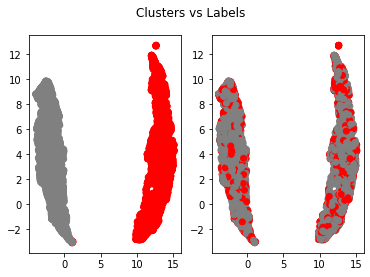

Epoch: 01 | NMI: 0.010 | ARI: 0.010 | Base_F1: 0.012 | Base_MCC: 0.049 | Base_AUC: 0.579 | CAC_F1: 0.061 | CAC_MCC: 0.104 | CAC_AUC: 0.499
Class Dist:  tensor(0.0002)
Class Dist:  tensor(0.0002)
KM Dist:  tensor(10598.0420, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.9222)
Epoch: 01 | Batch: 001 | Loss: 10861.280 | Rec-Loss: 264.160 | Dist-Loss: 10597.120
Class Dist:  tensor(0.0003)
Class Dist:  tensor(0.0002)
KM Dist:  tensor(8917.5010, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1696)
Epoch: 01 | Batch: 002 | Loss: 9195.373 | Rec-Loss: 279.042 | Dist-Loss: 8916.331
converged at itr:  2
Class Dist:  tensor(0.0005)
Class Dist:  tensor(0.0003)
KM Dist:  tensor(6758.0801, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.5985)
Epoch: 01 | Batch: 003 | Loss: 7045.520 | Rec-Loss: 289.039 | Dist-Loss: 6756.481
Class Dist:  tensor(0.0006)
Class Dist:  tensor(0.0003)
KM Dist:  tensor(5330.7231, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-2.0305)
Epoch: 01 | Batch: 004 | Loss: 5628.333 | Rec-Loss:

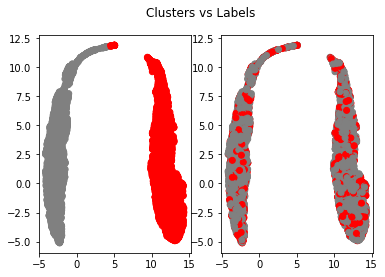

Epoch: 02 | NMI: 0.009 | ARI: 0.009 | Base_F1: 0.000 | Base_MCC: -0.015 | Base_AUC: 0.608 | CAC_F1: 0.027 | CAC_MCC: 0.069 | CAC_AUC: 0.497
converged at itr:  2
Class Dist:  tensor(0.0008)
Class Dist:  tensor(0.0004)
KM Dist:  tensor(3233.6238, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-3.1353)
Epoch: 02 | Batch: 001 | Loss: 3529.229 | Rec-Loss: 298.741 | Dist-Loss: 3230.489
converged at itr:  1
Class Dist:  tensor(0.0013)
Class Dist:  tensor(0.0006)
KM Dist:  tensor(2551.0056, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-3.7407)
Epoch: 02 | Batch: 002 | Loss: 2841.053 | Rec-Loss: 293.788 | Dist-Loss: 2547.265
Class Dist:  tensor(0.0014)
Class Dist:  tensor(0.0007)
KM Dist:  tensor(2802.1357, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-3.7412)
Epoch: 02 | Batch: 003 | Loss: 3090.261 | Rec-Loss: 291.867 | Dist-Loss: 2798.395
Class Dist:  tensor(0.0011)
Class Dist:  tensor(0.0005)
KM Dist:  tensor(2687.9856, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-3.8418)
Epoch: 02 | Batch: 004 | Loss: 2

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


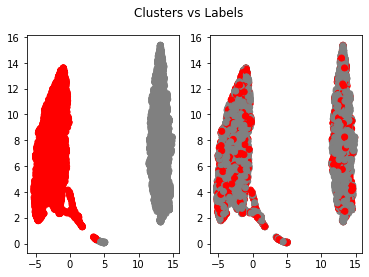

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 03 | NMI: 0.007 | ARI: 0.008 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.612 | CAC_F1: 0.020 | CAC_MCC: 0.060 | CAC_AUC: 0.493
Class Dist:  tensor(0.0020)
Class Dist:  tensor(0.0007)
KM Dist:  tensor(2057.5637, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-5.6521)
Epoch: 03 | Batch: 001 | Loss: 2312.086 | Rec-Loss: 260.175 | Dist-Loss: 2051.912
converged at itr:  2
Class Dist:  tensor(0.0023)
Class Dist:  tensor(0.0007)
KM Dist:  tensor(1559.1520, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-6.0940)
Epoch: 03 | Batch: 002 | Loss: 1810.964 | Rec-Loss: 257.906 | Dist-Loss: 1553.058
Class Dist:  tensor(0.0022)
Class Dist:  tensor(0.0007)
KM Dist:  tensor(1591.8251, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-6.2239)
Epoch: 03 | Batch: 003 | Loss: 1834.903 | Rec-Loss: 249.302 | Dist-Loss: 1585.601
converged at itr:  2
Class Dist:  tensor(0.0033)
Class Dist:  tensor(0.0009)
KM Dist:  tensor(1474.1376, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-6.4165)
Epoch: 03 | Batch: 004 | Loss: 17

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


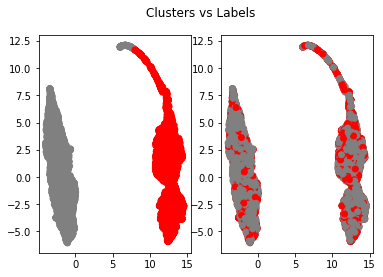

/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Epoch: 04 | NMI: 0.007 | ARI: 0.008 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.602 | CAC_F1: 0.020 | CAC_MCC: 0.051 | CAC_AUC: 0.508
converged at itr:  1
Class Dist:  tensor(0.0024)
Class Dist:  tensor(0.0007)
KM Dist:  tensor(1219.0708, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-6.9753)
Epoch: 04 | Batch: 001 | Loss: 1444.415 | Rec-Loss: 232.319 | Dist-Loss: 1212.095
Class Dist:  tensor(0.0032)
Class Dist:  tensor(0.0009)
KM Dist:  tensor(841.7408, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-8.7092)
Epoch: 04 | Batch: 002 | Loss: 1060.812 | Rec-Loss: 227.781 | Dist-Loss: 833.032
Class Dist:  tensor(0.0036)
Class Dist:  tensor(0.0010)
KM Dist:  tensor(825.2854, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-9.4074)
Epoch: 04 | Batch: 003 | Loss: 1041.468 | Rec-Loss: 225.590 | Dist-Loss: 815.878
converged at itr:  1
Class Dist:  tensor(0.0030)
Class Dist:  tensor(0.0008)
KM Dist:  tensor(898.2452, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-8.4307)
Epoch: 04 | Batch: 004 | Loss: 1109.60

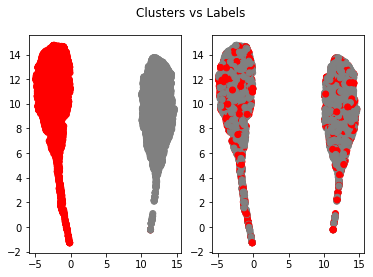

Epoch: 05 | NMI: 0.007 | ARI: 0.008 | Base_F1: 0.000 | Base_MCC: 0.000 | Base_AUC: 0.588 | CAC_F1: 0.027 | CAC_MCC: 0.088 | CAC_AUC: 0.505


/Users/shivin/miniconda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [40]:
# k-Means DCN
reducer = umap.UMAP()
for e in range(args.epoch):
    model.train()
    model.fit(e, train_loader)
    model.eval()
    out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
    cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
    X2 = reducer.fit_transform(out.cpu().detach().numpy())
    c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
    c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Clusters vs Labels')
    ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
    ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
    plt.show()

    out = evaluate(model, test_loader)  # evaluation on the test_loader
    if len(out) > 2:
        NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
            e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))
    else:
        NMI, ARI = out
        print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f}'.format(e+1, NMI, ARI))

    nmi_list.append(NMI)
    ari_list.append(ARI)

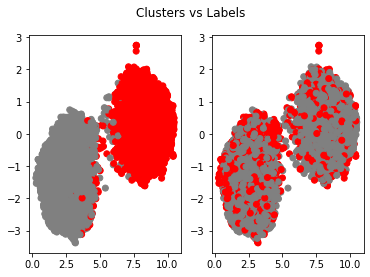

<Figure size 432x288 with 0 Axes>

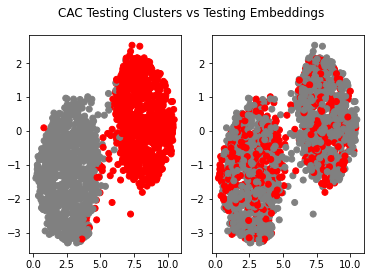

Class Dist:  tensor(5.3057e-05)
Class Dist:  tensor(2.6342e-05)
KM Dist:  tensor(51213.9531, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.1688)
Epoch: 00 | Batch: 001 | Loss: 51279.645 | Rec-Loss: 65.860 | Dist-Loss: 51213.785
Class Dist:  tensor(4.7289e-05)
Class Dist:  tensor(2.3738e-05)
KM Dist:  tensor(40510.9922, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.1596)
Epoch: 00 | Batch: 002 | Loss: 40599.094 | Rec-Loss: 88.260 | Dist-Loss: 40510.832
Class Dist:  tensor(6.0153e-05)
Class Dist:  tensor(3.6253e-05)
KM Dist:  tensor(29211.5215, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.2203)
Epoch: 00 | Batch: 003 | Loss: 29351.453 | Rec-Loss: 140.153 | Dist-Loss: 29211.301
Class Dist:  tensor(0.0001)
Class Dist:  tensor(9.2083e-05)
KM Dist:  tensor(21324.0977, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.3538)
Epoch: 00 | Batch: 004 | Loss: 21513.695 | Rec-Loss: 189.952 | Dist-Loss: 21323.744
Class Dist:  tensor(0.0001)
Class Dist:  tensor(0.0002)
KM Dist:  tensor(16036.7539, grad_fn=<

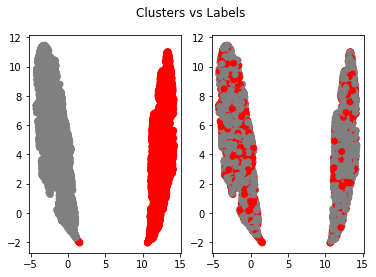

<Figure size 432x288 with 0 Axes>

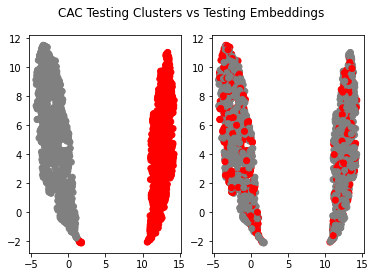

converged at itr:  2
Class Dist:  tensor(0.0002)
Class Dist:  tensor(0.0003)
KM Dist:  tensor(11188.9521, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-0.8256)
Epoch: 01 | Batch: 001 | Loss: 11483.183 | Rec-Loss: 295.056 | Dist-Loss: 11188.127
Class Dist:  tensor(0.0002)
Class Dist:  tensor(0.0004)
KM Dist:  tensor(9134.6709, grad_fn=<AddBackward0>)
Sep Dist:  tensor(-1.1051)
Epoch: 01 | Batch: 002 | Loss: 9446.039 | Rec-Loss: 312.474 | Dist-Loss: 9133.565


In [ ]:
# model.args.alpha = 4
# model.clustering = initial_clustering
reducer = umap.UMAP()
for e in range(args.epoch):
    # Print training set
    if e%1 == 0:
        out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
        cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X2 = reducer.fit_transform(out.cpu().detach().numpy())
#         X2 = out.cpu().detach().numpy()
#         X_centers = reducer.transform(model.clustering.clusters)

        c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
        c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]
        # plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#         ax1.plot(X_centers[0], marker='x', markersize=3, color="green")
#         ax1.plot(X_centers[1], marker='x', markersize=3, color="green")

        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        # Print testset
        out = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
        test_cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X_t = reducer.transform(out.cpu().detach().numpy())
#         X_t = out.cpu().detach().numpy()

        c_clusters = [color[int(test_cluster_id[i])] for i in range(len(test_cluster_id))]
        c_test = [color[int(y_test[i])] for i in range(len(y_test))]

        figure = plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CAC Testing Clusters vs Testing Embeddings')
        ax1.scatter(X_t[:,0], X_t[:,1], color=c_clusters)
        ax2.scatter(X_t[:,0], X_t[:,1], color=c_test)
        plt.show()

    model.train()
    model.fit(e, train_loader)

    model.eval()
    out = evaluate(model, test_loader)  # evaluation on the test_loader
    print(out)
    if len(out) > 2:
        NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc = out
    else:
        NMI, ARI = out
    nmi_list.append(NMI)
    ari_list.append(ARI)

    print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_MCC: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_MCC: {:.3f} | CAC_AUC: {:.3f}'.format(
            e+1, NMI, ARI, base_f1, base_mcc, base_auc, cac_f1, cac_mcc, cac_auc))


In [ ]:
params['n_clusters'] = 3
args = parameters(params)
datasets = ['titanic', 'magic', 'creditcard', 'adult', 'diabetes', 'cic', 'synthetic', 'new_synthetic']

In [ ]:
if args.dataset in datasets:
    base_dir = "../../CAC_code/data"
    print("Loading Dataset:", args.dataset)
    if args.dataset == "synthetic":
        n_feat = 45
        X, y = create_imbalanced_data_clusters(n_samples=500, n_clusters=2, n_features = n_feat, inner_class_sep=0.2, seed=0)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    elif args.dataset == "paper_synthetic":
        n_feat = 100
        X, y = paper_synthetic(10000)
        X = pd.DataFrame(X)
        y = pd.DataFrame(y)
        args.input_dim = n_feat

    else:
        X, y = get_dataset(args.dataset, base_dir)
        args.input_dim = X.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)

    X_train_data_loader = list(zip(X_train.astype(np.float32), y_train))
    X_test_data_loader  = list(zip(X_test.astype(np.float32), y_test))

    train_loader = torch.utils.data.DataLoader(X_train_data_loader,
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(X_test_data_loader, 
        batch_size=args.batch_size, shuffle=False)

elif args.dir == "../datasets/mnist":
    # Load data
    transformer = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.1307,),
                                                           (0.3081,))])

    train_set = datasets.MNIST(args.dir, train=True, download=True, transform=transformer)
    test_set  = datasets.MNIST(args.dir, train=False, transform=transformer)
    train_limit = list(range(0, len(train_set))) if not args.test_run else list(range(0, 500))    
    test_limit  = list(range(0, len(test_set)))  if not args.test_run else list(range(0, 500))    

    train_loader = torch.utils.data.DataLoader(Subset(train_set, train_limit),
        batch_size=args.batch_size, shuffle=True)

    test_loader = torch.utils.data.DataLoader(Subset(test_set, test_limit), 
        batch_size=args.batch_size, shuffle=False)

In [ ]:
model3 = DCN(args)
rec_loss_list = model3.pretrain(train_loader, epoch=args.pre_epoch)
pre_trained_AE = model3.autoencoder
# model.autoencoder = pre_trained_AE
# initial_clustering = model.clustering
# model.pre_cluster(train_loader)
# model.pre_cluster(train_loader)
nmi_list = []
ari_list = []

In [ ]:
model3.args = args
# model.clustering = initial_clustering
reducer = umap.UMAP()
for e in range(args.epoch):
    # Show training set
    if e%1 == 0:
        out = model.autoencoder(torch.FloatTensor(np.array(X_train)).to(args.device), latent=True)
        cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X2 = reducer.fit_transform(out.cpu().detach().numpy())

#         X_centers = reducer.transform(model.clustering.clusters)

        c_clusters = [color[int(cluster_id[i])] for i in range(len(cluster_id))]
        c_labels = [color[int(y_train[i])] for i in range(len(cluster_id))]
        # plt.scatter(latent_X[:,0], latent_X[:,1], color=c_train); plt.show()

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Clusters vs Labels')
        ax1.scatter(X2[:,0], X2[:,1], color=c_clusters)
#         ax1.plot(X_centers[0], marker='x', markersize=3, color="green")
#         ax1.plot(X_centers[1], marker='x', markersize=3, color="green")

        ax2.scatter(X2[:,0], X2[:,1], color=c_labels)
        plt.show()

        # Print testset
        out = model.autoencoder(torch.FloatTensor(np.array(X_test)).to(args.device), latent=True)
        test_cluster_id = model.clustering.update_assign(out.cpu().detach().numpy())
        X_t = reducer.transform(out.cpu().detach().numpy())

        c_clusters = [color[int(test_cluster_id[i])] for i in range(len(test_cluster_id))]
        c_test = [color[int(y_test[i])] for i in range(len(y_test))]

        figure = plt.figure()
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('CAC Testing Clusters vs Testing Embeddings')
        ax1.scatter(X_t[:,0], X_t[:,1], color=c_clusters)
        ax2.scatter(X_t[:,0], X_t[:,1], color=c_test)
        plt.show()

    model.train()
    model.fit(e, train_loader)

    model.eval()
    NMI, ARI, base_f1, base_auc, cac_f1, cac_auc = evaluate(model, test_loader)  # evaluation on the test_loader
    nmi_list.append(NMI)
    ari_list.append(ARI)

    print('Epoch: {:02d} | NMI: {:.3f} | ARI: {:.3f} | Base_F1: {:.3f} | Base_AUC: {:.3f} | CAC_F1: {:.3f} | CAC_F1: {:.3f}'.format(
        e+1, NMI, ARI, base_f1, base_auc, cac_f1, cac_auc))
